In [64]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/data-analytics-ue-22-cs-342-aa-2-hackathon-2/sample_submission.csv
/kaggle/input/data-analytics-ue-22-cs-342-aa-2-hackathon-2/train.csv
/kaggle/input/data-analytics-ue-22-cs-342-aa-2-hackathon-2/test.csv


In [65]:
train = pd.read_csv("/kaggle/input/data-analytics-ue-22-cs-342-aa-2-hackathon-2/train.csv")
test = pd.read_csv("/kaggle/input/data-analytics-ue-22-cs-342-aa-2-hackathon-2/test.csv")

In [66]:
train.head()
test.head()

,timestamp,rides_completed,driver_availability,surge_multiplier,vehicle_type,weather,traffic_index,special_event
0,2023-05-26 05:00:00,10,30.000000,1.3,car,Cloudy,99,0
1,2023-05-26 05:00:00,274,71.945314,1.0,bike,Clear,26,0
2,2023-05-26 05:00:00,341,38.421681,1.2,auto,Rainy,62,0
3,2023-05-26 06:00:00,81,31.053947,1.0,car,Cloudy,77,0
4,2023-05-26 06:00:00,268,52.334213,1.2,bike,Rainy,32,0


### Task 1: Data Exploration and Preparation (1 mark)

- Conduct exploratory data analysis to identify trends, patterns, and anomalies in fare data for each vehicle type (bikes, autos, and cars) in Quahog City.
- Using appropriate visualizations and techniques, provide an in-depth analysis on the nature of the average fare and other features in the dataset.

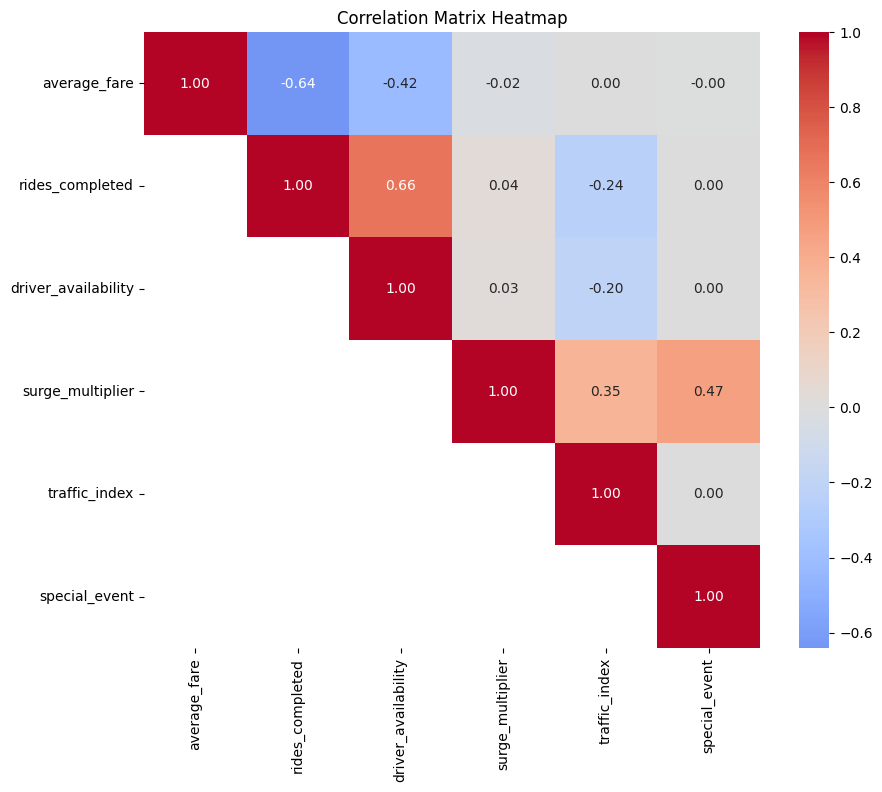

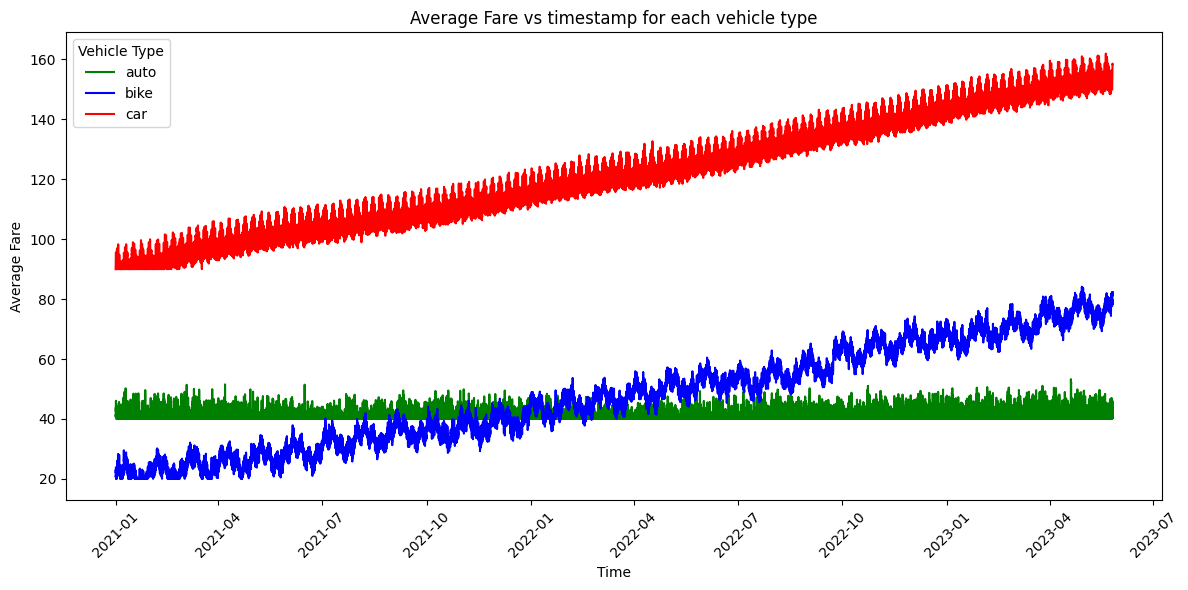

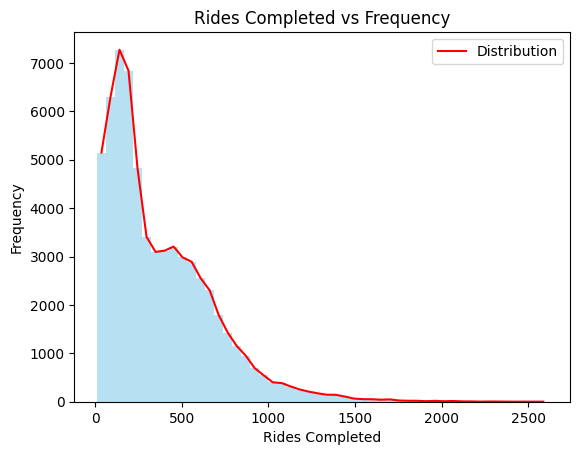

Failed to reject null hypothesis, there is no change in average fare based on the different weather conditions


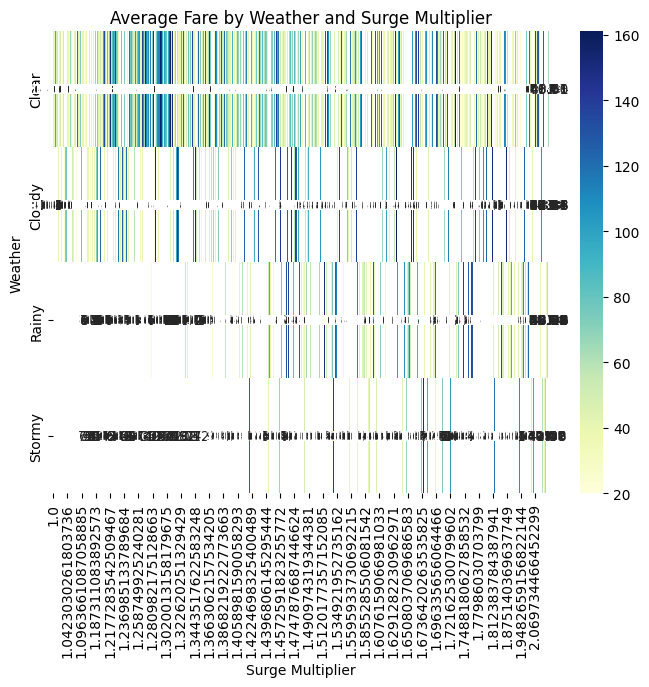

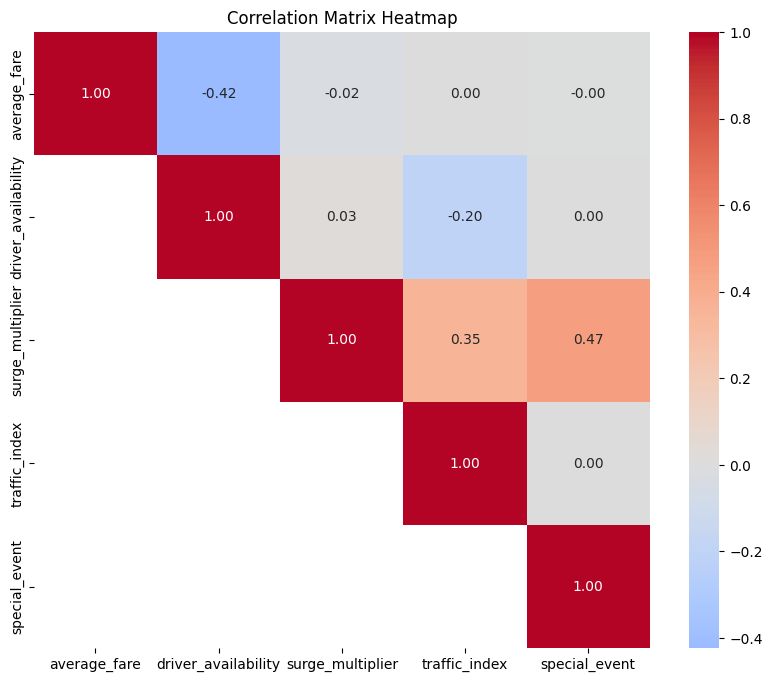

,timestamp,average_fare,driver_availability,surge_multiplier,vehicle_type,traffic_index,special_event,weather_Clear,weather_Cloudy,weather_Rainy,weather_Stormy
0,2021-01-01 00:00:00,20.780423,49.170948,1.0,bike,63,0,1,0,0,0
1,2021-01-01 00:00:00,90.000000,30.000000,1.0,car,53,0,1,0,0,0
2,2021-01-01 00:00:00,41.197085,39.110219,1.0,auto,35,0,1,0,0,0
3,2021-01-01 01:00:00,20.772227,30.000000,1.5,bike,83,0,0,0,0,1
4,2021-01-01 01:00:00,90.969805,30.000000,1.0,car,26,0,1,0,0,0


In [67]:
# Your code along with reasoning

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# train['vehicle_type'] = train['vehicle_type'].astype('category')
# train['weather'] = train['weather'].astype('category')
# train['special_event'] = train['special_event'].astype('category')

train['timestamp'] = pd.to_datetime(train['timestamp'])
test.drop(columns = ['rides_completed'], inplace = True)
test['timestamp'] = pd.to_datetime(test['timestamp'])
ts = test['timestamp']
test.drop(columns = ['timestamp'],inplace = True)
test['vehicle_type'] = test['vehicle_type'].astype('category')

train.dropna(inplace = True)

train.head()

#Step 1: check for imbalances in the dataset

ride_counts = train.groupby('vehicle_type').count()
ride_counts.head()

# As seen in the ride_counts df, there are equal number of data points for all the vehicle types.

#Step 2: Visualise average ride fair against different vehicle types


def find_plot_avg_fare(train,comp):
    avg_fare = train.groupby([comp, 'vehicle_type'])['average_fare'].mean().reset_index()


    colors = {
        'auto': 'green',
        'bike': 'blue',
        'car':'red'
             }
    plt.figure(figsize=(12, 6))

    for vehicle_type in avg_fare['vehicle_type'].unique():
        vehicle_data = avg_fare[avg_fare['vehicle_type'] == vehicle_type]
        plt.plot(vehicle_data[comp], vehicle_data['average_fare'], label=vehicle_type,color = colors[vehicle_type])

    # Add labels and title
    plt.xlabel('Time')
    plt.ylabel('Average Fare')
    plt.title(f'Average Fare vs {comp} for each vehicle type')
    plt.legend(title='Vehicle Type')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    


def find_plot_correlation(train):
    train_numeric_only = train.select_dtypes(include= ['number','bool'])
    correlation_matrix = train_numeric_only.corr()
    
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, square=True, fmt=".2f",mask = ~mask)
    plt.title("Correlation Matrix Heatmap")
    plt.show()
    
    
def find_plot_rides_completed(train):
#     plt.hist(train['rides_completed'],bins = 50,)
#     plt.title("Rides Completed vs Frequency")
#     plt.xlabel("Rides Completed")
#     plt.ylabel("Frequency")
#     plt.show()
    counts, bins, _ = plt.hist(train['rides_completed'], bins=50, alpha=0.6, color='skyblue')
    
    bin_centers = 0.5 * (bins[1:] + bins[:-1])

    plt.plot(bin_centers, counts, '-', color='red', label='Distribution')
    plt.title("Rides Completed vs Frequency")
    plt.xlabel("Rides Completed")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()
    
    
def one_way_anova(train):
    #perform anova test between weather and average_fare
    import scipy.stats as stats

    weather_data = train.groupby(['weather'])['average_fare'].mean()

    f_stat,p_stat = stats.f_oneway(*[train[train['weather'] == weather]['average_fare'] for weather in train['weather'].unique()])
    if p_stat < 0.05:
        print("Reject Null Hypothesis, there is a change in average fare based on the different weather conditions")
    else:
        print("Failed to reject null hypothesis, there is no change in average fare based on the different weather conditions")
        
def gna(train):
    grouped_data = train.groupby(['weather', 'surge_multiplier'])['average_fare'].mean().unstack()
    plt.figure(figsize=(8, 6))
    sns.heatmap(grouped_data, cmap='YlGnBu', annot=True, fmt=".2f")
    plt.title("Average Fare by Weather and Surge Multiplier")
    plt.xlabel("Surge Multiplier")
    plt.ylabel("Weather")
    plt.show()

    
#p_stat of 0.3874462413606528 suggests that the null hypothesis be rejected, i.e no significant change in fare through different weather
find_plot_correlation(train)
#check if any of the variables are strongly correlated.
#Avg_fare and rides_completed are strongly negatively correlated
#rides_completed and driver_availavility are strongly postively correlated.
#Surge_multiplier and special_event have a moderate positive correlation
#surge_multiplier and traffic index have a weak positive correlation
#traffic_index and driver_availability have a weak negative correlation
#traffic_index and rides_completed have a weak negative correlation
#Avg_fare and driver_availability have a moderate negative correlation.

find_plot_avg_fare(train,'timestamp')
#Increasing trend is observed in average fare of car and bike with time whereas auto remains relatively constant.
#This indicates that the time series data for car and bike could be non stationary but auto could be stationary
#Further analysis with the ADF test is required before conclusions can be made.

# find_plot_avg_fare(train,'weather')


find_plot_rides_completed(train)


one_way_anova(train)
#Failed to reject null hypothesis, 
#there is no change in average fare based on the different weather conditions based on the p value from the one way anova test

gna(train)

#Stormy/rainy have higher surge_multipliers and higher fares


train = train.drop(['rides_completed'],axis = 1)

find_plot_correlation(train)


train = pd.get_dummies(train,columns = ['weather'],dtype=int)
test = pd.get_dummies(test,columns = ['weather'],dtype = int)

train.head()

### Task 2: Time Series Characterization (1 mark)

- Building on your exploratory analysis, examine the time series characteristics of the average fare for each vehicle type in Quahog City.
- Implement the Holt and Holt-Winters methods to model and forecast the average fare for each vehicle type.
- Interpret the results and discuss the implications for RideWave's business.

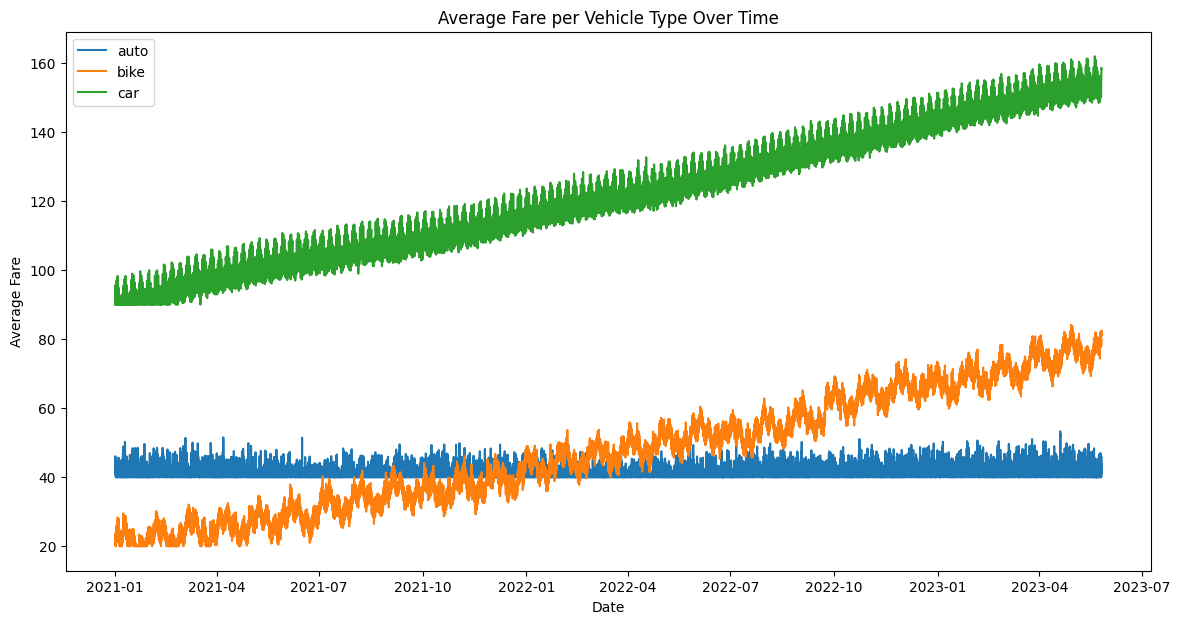


Stationarity Test for auto:
ADF Statistic: -20.739513354918834
p-value: 0.0
Critical Values:
   1%: -3.4306618194195084
   5%: -2.8616778135768097
   10%: -2.5668433543400266


/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


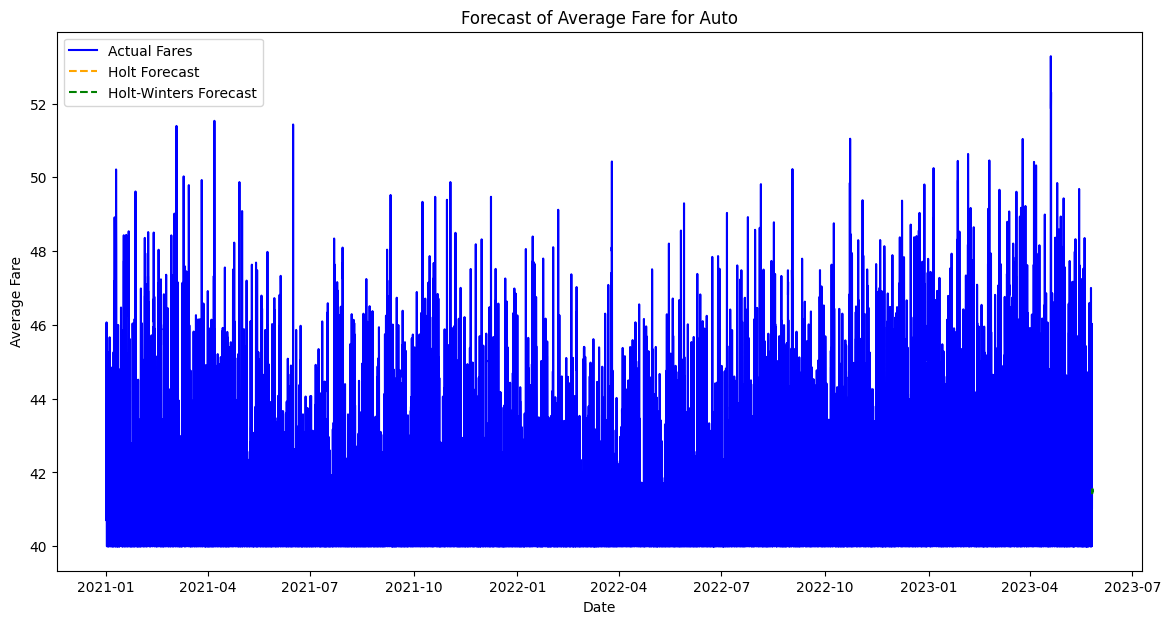


Stationarity Test for bike:
ADF Statistic: -1.5575504421726767
p-value: 0.5048745215832674
Critical Values:
   1%: -3.4306620575014812
   5%: -2.8616779187954124
   10%: -2.5668434103459283
Bike fare series is not stationary. Consider differencing or transformation.

Stationarity Test for car:
ADF Statistic: -1.8619436504858908
p-value: 0.3501702333000294
Critical Values:
   1%: -3.4306620575014812
   5%: -2.8616779187954124
   10%: -2.5668434103459283
Car fare series is not stationary. Consider differencing or transformation.


In [68]:
from statsmodels.tsa.holtwinters import Holt, ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller


average_fares = train.groupby(['timestamp', 'vehicle_type'])['average_fare'].mean().reset_index()

# Your code along with reasoning
pivoted_fares = average_fares.pivot(index='timestamp', columns='vehicle_type', values='average_fare')
# pivoted_fares.head()
# Plotting average fares over time
plt.figure(figsize=(14, 7))
for vehicle in pivoted_fares.columns:
    plt.plot(pivoted_fares.index, pivoted_fares[vehicle], label=vehicle)
plt.title('Average Fare per Vehicle Type Over Time')
plt.xlabel('Date')
plt.ylabel('Average Fare')
plt.legend()
plt.show()

def adf_test(series):
    result = adfuller(series)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')

# Step 5: Analyze each vehicle type
for vehicle in pivoted_fares.columns:
    print(f"\nStationarity Test for {vehicle}:")
    adf_test(pivoted_fares[vehicle])

    # Step 6: Holt's Linear Trend Model for stationary series
    if adfuller(pivoted_fares[vehicle])[1] < 0.05:
        model_holt = Holt(pivoted_fares[vehicle]).fit()
        forecast_holt = model_holt.forecast(steps=12)  # Forecast next 12 periods

        # Step 7: Holt-Winters Seasonal Model
        model_hw = ExponentialSmoothing(
            pivoted_fares[vehicle],
            seasonal='add',  # or 'mul', depending on the seasonality observed
            seasonal_periods=24  # Adjust this based on your data frequency
        ).fit()

        forecast_hw = model_hw.forecast(steps=12)

        # Step 8: Plotting the results
        plt.figure(figsize=(14, 7))
        plt.plot(pivoted_fares.index, pivoted_fares[vehicle], label='Actual Fares', color='blue')
        plt.plot(forecast_holt.index, forecast_holt, label='Holt Forecast', color='orange', linestyle='--')
        plt.plot(forecast_hw.index, forecast_hw, label='Holt-Winters Forecast', color='green', linestyle='--')
        plt.title(f'Forecast of Average Fare for {vehicle.capitalize()}')
        plt.xlabel('Date')
        plt.ylabel('Average Fare')
        plt.legend()
        plt.show()
    else:
        print(f"{vehicle.capitalize()} fare series is not stationary. Consider differencing or transformation.")

# adf_test(train)

### Task 3: Advanced Forecasting and Feature Engineering (1 mark)

Leveraging insights from Tasks 1 and 2, develop more sophisticated time series models to forecast future average fares for each vehicle type.
- Implement at least one advanced forecasting method (e.g., ARIMA/ARIMAX, SARIMA/SARIMAX, or another technique of your choice).
- Perform feature engineering to incorporate additional relevant variables beyond just the time component to enhance your fare predictions.
- After completing your feature engineering process, list and explain the top 3 most influential features that affect fare predictions, supported by appropriate metrics or visualizations.
- Explain your choice of forecasting method and the rationale behind your feature engineering process.
- Interpret your model results and fare forecasts, relating them to RideWave's operations and the dynamics of fare pricing across different vehicle types.

ADF Statistic: -14.351295209935772
p-value: 1.0206790891507277e-26
Critical Values:
   1%: -3.4306620723936763
   5%: -2.86167792537691
   10%: -2.5668434138491367
ADF Statistic: -18.42482078681372
p-value: 2.1733345858601402e-30
Critical Values:
   1%: -3.4306620723936763
   5%: -2.86167792537691
   10%: -2.5668434138491367


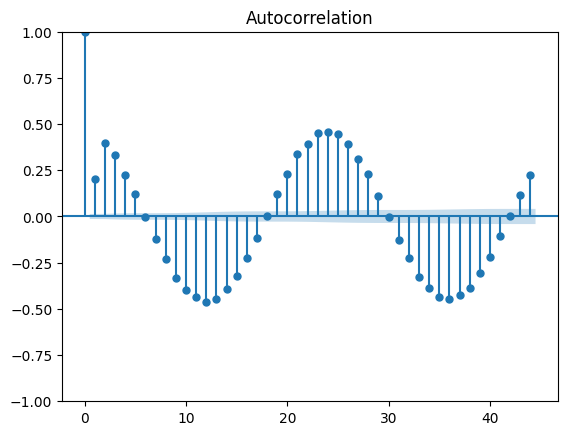

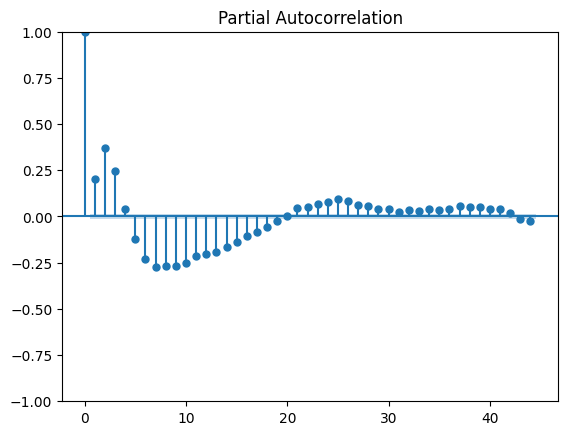

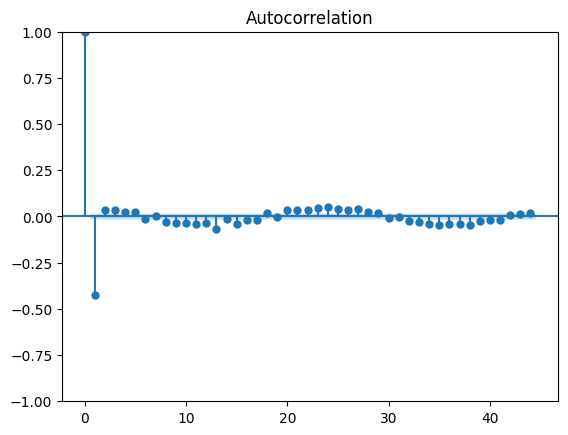

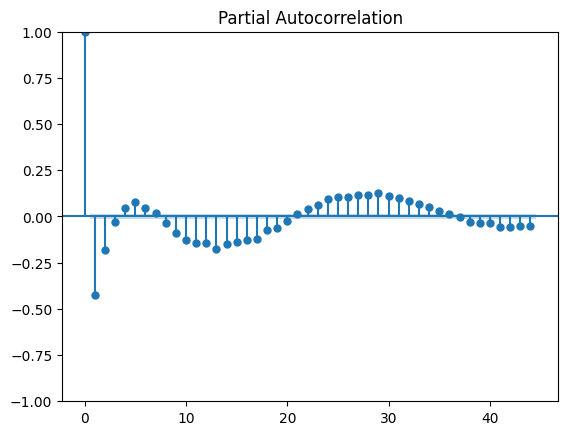

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.49003D+00    |proj g|=  1.87966D-01


 This problem is unconstrained.



At iterate    5    f=  1.48999D+00    |proj g|=  4.64522D-02

At iterate   10    f=  1.48998D+00    |proj g|=  1.97439D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     12     22      1     0     0   1.122D-02   1.490D+00
  F =   1.4899840751100322     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [69]:
# Your code along with reasoning
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

average_fares.head()

cars_avg_fare = average_fares[average_fares['vehicle_type'].isin(['car'])]
bikes_avg_fare = average_fares[average_fares['vehicle_type'].isin(['bike'])]


diff_cars = np.diff(cars_avg_fare['average_fare'])
diff_bikes = np.diff(bikes_avg_fare['average_fare'])

adf_test(diff_cars) 
adf_test(diff_bikes)
#p values of 1.0206790891507277e-26 and 2.1733345858601402e-30 indicate that differencing
#cars and bikes average fares has made the both of the series stationary


plot_acf(diff_cars, alpha = 0.05,label = "ACF for cars")  
plt.show()

plot_pacf(diff_cars, alpha = 0.05,label = "PACF for cars")  
plt.show()
#from the ACF and PACF plots we can infer a value of p = 1 and q = 1


plot_acf(diff_bikes, alpha = 0.05,label = "ACF for bikes")  
plt.show()

plot_pacf(diff_bikes, alpha = 0.05,label = "PACF for bikes")  
plt.show()
#from the ACF and PACF plots we can infer a value of p = 1 and q = 1

exog_vars = train[['weather_Cloudy','weather_Clear','weather_Rainy','weather_Stormy','special_event','traffic_index','surge_multiplier','driver_availability']]


aligned_data = pd.merge(pd.DataFrame(diff_cars), pd.DataFrame(exog_vars), left_index=True, right_index=True)

# Extract aligned data
aligned_diff_cars = aligned_data[0]
aligned_exog_vars = aligned_data.drop(0, axis=1)


model_cars = SARIMAX(aligned_diff_cars, order=(1,0,0), seasonal_order=(0,0,0,12),exog = aligned_exog_vars)
results_cars = model_cars.fit()


In [70]:
from sklearn.metrics import mean_squared_error,mean_absolute_error

sarimax_forecast = results_cars.get_forecast(steps=len(aligned_exog_vars), exog=aligned_exog_vars).predicted_mean
mse_cars = mean_squared_error(aligned_diff_cars, sarimax_forecast)
mae_cars = mean_absolute_error(aligned_diff_cars,sarimax_forecast)
print(mse_cars)
print(mae_cars)

1.1966311733260413
0.870190483943824


In [71]:
aligned_data = pd.merge(pd.DataFrame(diff_bikes), pd.DataFrame(exog_vars), left_index=True, right_index=True)

# Extract aligned data
aligned_diff_bikes = aligned_data[0]
aligned_exog_vars_bikes = aligned_data.drop(0, axis=1)

model_bikes = SARIMAX(aligned_diff_bikes, order=(1,0,1), seasonal_order=(0,0,0,12),exog = aligned_exog_vars_bikes)
results_bikes = model_bikes.fit()

# As seen in the model results, the SARIMAX model fits at the 40th iteration indicating a good fit.
#This can be considered a positive sign to using SARIMAX for bikes in the ensemble

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.54996D+00    |proj g|=  3.68428D-01

At iterate    5    f=  1.54964D+00    |proj g|=  3.41106D-01

At iterate   10    f=  1.54949D+00    |proj g|=  1.37638D-01

At iterate   15    f=  1.54905D+00    |proj g|=  1.86453D+00

At iterate   20    f=  1.54882D+00    |proj g|=  5.80798D-03

At iterate   25    f=  1.54881D+00    |proj g|=  1.35530D-01

At iterate   30    f=  1.54879D+00    |proj g|=  2.42034D-02

At iterate   35    f=  1.54879D+00    |proj g|=  1.78701D-02

At iterate   40    f=  1.54879D+00    |proj g|=  4.51961D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

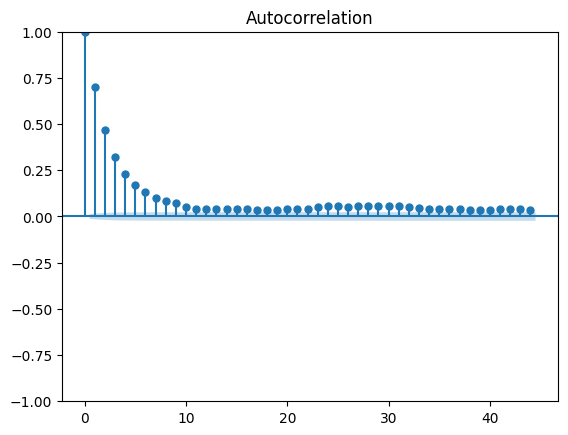

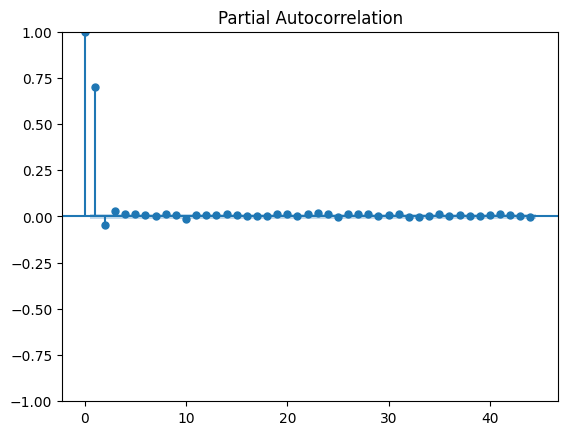

In [72]:
import statsmodels.api as sm

auto_avg_fare = average_fares[average_fares['vehicle_type'].isin(['auto'])]

plot_acf(auto_avg_fare['average_fare'], alpha = 0.05,label = "ACF for bikes")  
plt.show()

plot_pacf(auto_avg_fare['average_fare'], alpha = 0.05,label = "PACF for bikes")  
plt.show()

aligned_data = pd.merge(pd.DataFrame(auto_avg_fare['average_fare']), pd.DataFrame(exog_vars), left_index=True, right_index=True)

# aligned_data.head()

# Extract aligned data
aligned_auto = aligned_data[['average_fare']]
aligned_exog_vars_auto = aligned_data.drop(columns = ['average_fare'], axis=1)



In [73]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

#X_train, X_test, y_train, y_test = train_test_split(aligned_data.drop(columns=['average_fare']), aligned_auto['average_fare'], test_size=0.2, random_state=42)

rf_model = RandomForestRegressor(n_estimators=500, random_state=42)
split_point = int(0.8 * len(auto_avg_fare))
X_train_auto, X_test_auto = aligned_exog_vars_auto[:split_point], aligned_exog_vars_auto[split_point:]
y_train_auto, y_test_auto = aligned_auto[:split_point], aligned_auto[split_point:]

rf_model.fit(aligned_exog_vars_auto,aligned_auto.values.ravel())

y_pred = rf_model.predict(X_test_auto)

mse = mean_squared_error(y_test_auto, y_pred)
r2 = r2_score(y_test_auto, y_pred)
mae = mean_absolute_error(y_test, y_pred)


print("Mean Squared Error:", mse)
print("R^2 Score:", r2)
print(mae)

feature_importances = rf_model.feature_importances_

importance_df = pd.DataFrame({
    'Feature': aligned_data.drop(columns=['average_fare']).columns,
    'Importance': feature_importances
})

top_features = importance_df.sort_values(by='Importance', ascending=False).head(3)
print("Top 3 Most Important Features:")
print(top_features)


Mean Squared Error: 1.4594285931386317
R^2 Score: 0.715777601278837
0.8372318074623346
Top 3 Most Important Features:
               Feature  Importance
7  driver_availability    0.532809
5        traffic_index    0.272871
6     surge_multiplier    0.137732


In [74]:
print(results_bikes.summary())
#From the summary of the SARIMAX model for bikes, we can see that the 3 most influential features are:
# ma.L1 : The current predicted value is highly dependent on the previous period's error
# ar.S.L12 indicates the relationship between the value at the current time and at the same time at previous season.
# Since the coefficient of ar.S.L12 is negative, it means that if the value was higher than normal at the same month last year, then the current value is expected to be lower than normal
# ar.L1 This indicates that the model is strongly correlated with its value in the previous period.
print(results_cars.summary())
#From the summary of the SARIMAX model for cars, we can see that the 3 most influential features are:
# ar.L1: This indicates that the model is strongly correlated with its value in the previous period.
# weather_Rainy: This indicates that the model is strongly correlated with the weather condition being rainy.
# weather_Clear: This indicates that the model is strongly correlated with the weather condition being clear.



                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                21004
Model:               SARIMAX(1, 0, 1)   Log Likelihood              -32530.649
Date:                Sun, 24 Nov 2024   AIC                          65083.298
Time:                        12:04:24   BIC                          65170.775
Sample:                             0   HQIC                         65111.850
                              - 21004                                         
Covariance Type:                  opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
weather_Cloudy         -0.1926      0.038     -5.071      0.000      -0.267      -0.118
weather_Clear          -0.1742      0.036     -4.799      0.000      -0.245      -0.103
weather_Rainy   

In [75]:
# Rationale behind model choice:

#ACF/PACF curve indicates seasonality in data hence the SARIMAX model was used.
# S in SARIMAX stands for Seasonality.
# SARIMAX works well with wide range of TS data including ones having trends and seasonality as is our case(though we removed trend by differencing)
# Random Forest was used for Auto TS as the data was stationary and not showing seasonality or trends. 

#Rationale behind feature engineering:
#Since the Correlogram showed strong positive correlation between avg_fare and rides_completed, rides_completed was dropped.
#The Correlogram fails to capture non-linear correlations hence it was decided to include all other features (including one hot encoded weather).
#This allowed us to analyse the contribution of each feature to the SARIMAX model.
#The ones having the highest values of abs(z) were considered as the most influential and retained.
#The top 3 were reported for both bikes and cars.


### Task 4: Ensemble Modeling and Pricing Strategy (1 mark)

- Based on your work from previous tasks, analyze the relationships between fares of different vehicle types in Quahog City.
- Develop 3 different sophisticated forecasting models **(one for each vehicle type)**, with appropriate feature engineering for each vehicle type.

You must use the following 3 models for your forecasting:

1. ARIMA / ARIMAX / SARIMA / SARIMAX
2. Any method of your choice
3.  Any method of your choice that is NOT in the following list: Holt Winter's, ARIMA, ARIMAX, SARIMA, SARIMAX
   


Here are some models you can consider:
1) ARCH (https://en.wikipedia.org/wiki/Autoregressive_conditional_heteroskedasticity)
2) GARCH (https://www.investopedia.com/terms/g/garch.asp)
3) VAR (https://en.wikipedia.org/wiki/Vector_autoregression#:~:text=VAR%20is%20a%20type%20of,economics%20and%20the%20natural%20sciences.)
4) XGBoost (https://en.wikipedia.org/wiki/XGBoost)

Explain the rationale behind your choice of model for the corresponding vehicle type.

RideWave are looking to create a unified model incorporating all 3 of the models you have developed.
- How would you go about implementing an ensemble modelling approach using all 3 models? 
##### (You don't have to write code for this, but the explanation must be detailed)





In [76]:
# Your code along with reasoning
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

X_train_bikes, X_test_bikes, y_train_bikes, y_test_bikes = train_test_split(
    aligned_exog_vars_bikes, aligned_diff_bikes, test_size=0.2, random_state=42
)

xgb_model_bikes = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
xgb_model_bikes.fit(X_train_bikes, y_train_bikes)

rf_model_bikes = RandomForestRegressor(
    n_estimators=100, 
    max_depth=10, 
    random_state=42
)
rf_model_bikes.fit(X_train_bikes, y_train_bikes)

bikes_forecast_xgb = xgb_model_bikes.predict(X_test_bikes)  
bikes_forecast_rf = rf_model_bikes.predict(X_test_bikes)
# bikes_forecast_sarimax = results_bikes.predict(X_test_bikes)
start_idx = len(X_train_bikes)
end_idx = start_idx + len(X_test_bikes) - 1
bikes_forecast_sarimax = results_bikes.predict(start=start_idx, end=end_idx)


weight_xgb_b = 1/mean_squared_error(y_test_bikes, bikes_forecast_xgb)
weight_rf_b = 1/mean_squared_error(y_test_bikes,bikes_forecast_rf)
weight_sarimax_b = 1/mean_squared_error(y_test_bikes,bikes_forecast_sarimax)

ensemble_forecast_bikes = (weight_xgb_b * bikes_forecast_xgb + weight_rf_b * bikes_forecast_rf + weight_sarimax_b * bikes_forecast_sarimax)
mse_bikes = mean_squared_error(y_test_bikes, ensemble_forecast_bikes)
print(mse_bikes)

#Reasoning behing model choice: 
#XGBoost uses decision trees which are good at capturing non linear relationships and then performs boosting to improve performance
#RandomForest uses decision trees which are good at capturing non linear relationships and then performs bagging to improve performance
#SARIMAX is a model used for time series forecasting when the data has seasonality and trend.

1.7905460816265524


In [77]:
train_columns = ['weather_Cloudy', 'weather_Clear', 'weather_Rainy', 'weather_Stormy', 
                 'special_event', 'traffic_index', 'surge_multiplier', 'driver_availability']
test = test[train_columns]

test_exog = test[['weather_Cloudy','weather_Clear','weather_Rainy','weather_Stormy','special_event','traffic_index','surge_multiplier','driver_availability']]
test_exog_rs_bc = test_exog[:10508]
test_exog_rs_a = test_exog[:14708]


In [78]:
# Your code along with reasoning
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

X_train_cars, X_test_cars, y_train_cars, y_test_cars = train_test_split(
    aligned_exog_vars, aligned_diff_cars, test_size=0.2, random_state=42
)

xgb_model_cars = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
xgb_model_cars.fit(X_train_cars, y_train_cars)

rf_model_cars = RandomForestRegressor(
    n_estimators=100, 
    max_depth=10, 
    random_state=42
)
rf_model_cars.fit(X_train_cars, y_train_cars)

cars_forecast_xgb = xgb_model_cars.predict(X_test_cars)  
cars_forecast_rf = rf_model_cars.predict(X_test_cars)
# bikes_forecast_sarimax = results_bikes.predict(X_test_bikes)
start_idx = len(X_test_cars)
end_idx = start_idx + len(X_test_cars) - 1
cars_forecast_sarimax = results_cars.predict(start=start_idx, end=end_idx)


weight_xgb_c = 1/mean_squared_error(y_test_cars, cars_forecast_xgb)
weight_rf_c = 1/mean_squared_error(y_test_cars,cars_forecast_rf)
weight_sarimax_c = 1/mean_squared_error(y_test_cars,cars_forecast_sarimax)

ensemble_forecast_cars = (weight_xgb_c * cars_forecast_xgb + weight_rf_c * cars_forecast_rf + weight_sarimax_c * cars_forecast_sarimax)
mse_cars = mean_squared_error(y_test_cars, ensemble_forecast_cars)
print(mse_cars)

#Reasoning behing model choice: 
#XGBoost uses decision trees which are good at capturing non linear relationships and then performs boosting to improve performance
#RandomForest uses decision trees which are good at capturing non linear relationships and then performs bagging to improve performance
#SARIMAX is a model used for time series forecasting when the data has seasonality and trend.

1.2869255763063983


In [80]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import StandardScaler
import numpy as np

# 1. First, scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_auto)
X_test_scaled = scaler.transform(X_test_auto)
# test_scaled = scaler.transform(test)

# 2. Improve XGBoost model
xgb_model_auto = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=200,
    learning_rate=0.05,  # Reduced learning rate for better generalization
    max_depth=6,
    min_child_weight=3,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb_model_auto.fit(
    X_train_scaled, 
    y_train_auto,
    eval_set=[(X_test_scaled, y_test_auto)],
    early_stopping_rounds=20,
    verbose=False
)

# 3. Improve Random Forest model
rf_model_auto = RandomForestRegressor(
    n_estimators=200,
    max_depth=12,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1  # Use all CPU cores
)
rf_model_auto.fit(X_train_scaled, y_train_auto)

# 4. Improve ARIMA model
# Try different orders
arma_auto = ARIMA(y_train_auto, exog=X_train_scaled, order=(2,0,2))  # Changed to ARMA(2,2)
results_auto = arma_auto.fit()

# 5. Generate predictions
auto_forecast_xgb = xgb_model_auto.predict(X_test_scaled)
auto_forecast_rf = rf_model_auto.predict(X_test_scaled)
start_idx = len(X_train_auto)
end_idx = start_idx + len(X_test_auto) - 1
auto_forecast_arima = results_auto.predict(start=start_idx, end=end_idx, exog=X_test_scaled)

# 6. Calculate weights using exponential weighting
mse_xgb = mean_squared_error(y_test_auto, auto_forecast_xgb)
mse_rf = mean_squared_error(y_test_auto, auto_forecast_rf)
mse_arima = mean_squared_error(y_test_auto, auto_forecast_arima)

weight_xgb_a = 1/mse_xgb
weight_rf_a = 1/mse_rf
weight_arima_a = 1/mse_arima

# Normalize weights
# total_weight = weight_xgb + weight_rf + weight_arima
# weight_xgb /= total_weight
# weight_rf /= total_weight
# weight_arima /= total_weight

# 7. Create weighted ensemble forecast
ensemble_forecast_auto = (
    weight_xgb_a * auto_forecast_xgb + 
    weight_rf_a * auto_forecast_rf + 
    weight_arima_a * auto_forecast_arima
)

# 8. Calculate and print individual and ensemble MSEs
print(f"Ensemble MSE: {mean_squared_error(y_test_auto, ensemble_forecast_auto):.2f}")

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/tmp/ipykernel_30/438486708.py:43: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model_auto.fit(X_train_scaled, y_train_auto)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An u

Ensemble MSE: 384.01


/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [ ]:
# print(f"Mean Squared Error (MSE): {mse_bikes}")
# print(f"Root Mean Squared Error (RMSE): {rmse_bikes}")
# print(f"Mean Absolute Error (MAE): {mae_bikes}")

In [ ]:
# weight_cars = 1/mse_cars
# weight_bikes = 1/mse_bikes
# weight_autos = 1/mse



# cars_forecast = results_cars.predict(start=aligned_diff_cars.index[0], end=aligned_diff_cars.index[-1], exog=aligned_exog_vars)
# autos_forecast = rf_model.predict(X_test)

# target_length = len(y_test)

# cars_forecast = np.array(cars_forecast[:target_length])
# bikes_forecast = np.array(bikes_forecast[:target_length])
# autos_forecast = np.array(autos_forecast[:target_length])

# cars_forecast = np.array(cars_forecast)
# bikes_forecast = np.array(bikes_forecast)
# autos_forecast = np.array(autos_forecast)

# ensemble_forecast = (
#     weight_cars * cars_forecast +
#     weight_bikes * bikes_forecast +
#     weight_autos * autos_forecast
# )

# print("Ensemble Forecast:", ensemble_forecast)

# mse_ensemble = mean_squared_error(y_test, ensemble_forecast)
# rmse_ensemble = np.sqrt(mse_ensemble)
# mae_ensemble = mean_absolute_error(y_test, ensemble_forecast)

# print("Ensemble Model Performance:")
# print(f"Mean Squared Error (MSE): {mse_ensemble}")
# print(f"Root Mean Squared Error (RMSE): {rmse_ensemble}")
# print(f"Mean Absolute Error (MAE): {mae_ensemble}")

## 

In [81]:
submission = pd.DataFrame()
bikes_forecast_xgb = xgb_model_bikes.predict(test)  
bikes_forecast_rf = rf_model_bikes.predict(test)
# bikes_forecast_sarimax = results_bikes.predict(X_test_bikes)
start_idx = len(test)
end_idx = start_idx + len(test) - 1
bikes_forecast_sarimax = results_bikes.predict(start=start_idx, end=end_idx,exog = test_exog_rs_bc)
ensemble_forecast_bikes = (weight_xgb_b * bikes_forecast_xgb + weight_rf_b * bikes_forecast_rf + weight_sarimax_b * bikes_forecast_sarimax)


cars_forecast_xgb = xgb_model_cars.predict(test)  
cars_forecast_rf = rf_model_cars.predict(test)
# bikes_forecast_sarimax = results_bikes.predict(X_test_bikes)
start_idx = len(test)
end_idx = start_idx + len(test) - 1
cars_forecast_sarimax = results_cars.predict(start=start_idx, end=end_idx,exog = test_exog_rs_bc)
ensemble_forecast_cars = (weight_xgb_c * cars_forecast_xgb + weight_rf_c * cars_forecast_rf + weight_sarimax_c * cars_forecast_sarimax)

test_scaled = scaler.transform(test)

auto_forecast_xgb = xgb_model_auto.predict(test_scaled)  
auto_forecast_rf = rf_model_auto.predict(test_scaled)
# bikes_forecast_sarimax = results_bikes.predict(X_test_bikes)
start_idx = len(test_scaled)
end_idx = start_idx + len(test_scaled) - 1
auto_forecast_sarimax = results_auto.predict(start=start_idx, end=end_idx,exog = test_exog_rs_a)
ensemble_forecast_auto = (
    weight_xgb_a * auto_forecast_xgb + 
    weight_rf_a * auto_forecast_rf + 
    weight_arima_a * auto_forecast_sarimax
)
#merge the three ensemble forecasts along with a df called ts

# pred_cars = 
# pred_bikes = ensemble_forecast[ensemble_forecast['vehicle_type'] == 'bike']
# pred_auto = ensemble_forecast[ensemble_forecast['vehicle_type'] == 'auto']

# ensemble_forecast_df = pd.DataFrame(ensemble_forecast, columns=['ensemble_forecast'])

# submission = pd.concat([pd.DataFrame(X_test), ensemble_forecast_df], axis=1)

# submission.head() 

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [85]:

ensemble_forecast_bikes = ensemble_forecast_bikes.reset_index(drop=True)
ensemble_forecast_auto = ensemble_forecast_auto.reset_index(drop=True)
ensemble_forecast_cars = ensemble_forecast_cars.reset_index(drop=True)
ts = ts.reset_index(drop=True)


submission['timestamp'] = ts
submission['average_fare_bike'] = ensemble_forecast_bikes
submission['average_fare_auto'] = ensemble_forecast_auto
submission['average_fare_car'] = ensemble_forecast_cars

## We have used a sample-submission just to show you the format your submission should be in, you have to use your OWN forecasts while making submissions


In [83]:
# submission['timestamp'] = sample_submission['timestamp']
# submission['average_fare_bike'] = sample_submission['average_fare_bike']
# submission['average_fare_auto'] = sample_submission['average_fare_auto']
# submission['average_fare_car'] = sample_submission['average_fare_car']

In [86]:
submission.head()

,timestamp,average_fare_bike,average_fare_auto,average_fare_car
0,2023-05-26 05:00:00,-0.240824,22.555814,-0.359402
1,2023-05-26 05:00:00,-0.026358,22.939705,-0.132675
2,2023-05-26 05:00:00,0.248707,22.594577,-0.511370
3,2023-05-26 06:00:00,-0.248506,22.402405,-0.181038
4,2023-05-26 06:00:00,0.089226,23.122009,-0.204238


In [ ]:
submission.to_csv('submission.csv', index = False)

## Congratulations! 🎉

You've done it! You've successfully completed the Data Analytics (UE22CS342AA2) Hackathon-2, and that's something to be truly proud of! This achievement shows just how much you've grown in your ability to tackle time-series modeling and analysis.

### Here’s what you’ve accomplished:
- You applied data analytics concepts to solve real-world problems.
- You developed time-series models, a skill that’s essential in fields like finance (think stock predictions) and healthcare (monitoring vitals)—and many more!

### What's next:
With this experience, you’ve laid a solid foundation for real-world data modeling and time-series analysis. The techniques you’ve mastered here will be incredibly valuable in many data science and machine learning projects, no matter the industry.

But remember, this is just the start of your journey in data science! Keep learning, keep pushing yourself, and most importantly, keep having fun with it. You're ready for even more exciting and challenging projects.

**Huge congrats once again, and wishing you all the best for your ISAs and ESAs! You've got this! 🌟** 